In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
from tqdm.notebook import tqdm
from statistics import mean

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

from models.old_model import SiameseNetwork
from models.new_model import NewSiameseNetwork
from models import pretrained_model

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine
from losses.triplet import TripletLoss

from utils.vis_utils import imshow, show_plot, example_vis
from utils.other_utils import joinpath, NetworkDataset, TestNetworkDataset, get_dataset
from utils.other_utils import intersection, threshold

from embeddings.create_embeddings import create_embeddings
from embeddings.mean_embeddings import mean_embeddings

from scoring.test_report import test_report

In [2]:
# Setup the path where images are located
PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\data\Automobile-parts"

# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=3

# no of epoch
EPOCH = 2000

# whether it is triplet or contrastive
FLAG = 'contrastive'
# FLAG = 'triplet'

# rotation flag
ROTATION = False

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())
    torch.cuda.empty_cache()

NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Resize the images and transform to tensors
if ROTATION:
    transformation = transforms.Compose([transforms.Resize((224,224)),
        transforms.ToTensor(), 
        transforms.RandomApply([
            transforms.RandomRotation([-30,30])], p = 0.2)
    ])
else:
    # transformation = transforms.Compose([transforms.Resize((100,100)),
    #                                  transforms.ToTensor()])
    transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] 
                                     )

In [4]:
os.cpu_count() #cpu count

16

In [5]:
test_dataloader,_ = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, True)

    # Grab one image that we are going to test
dataiter = iter(test_dataloader)
tensor,_ = next(dataiter)

In [6]:
tensor.size()

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


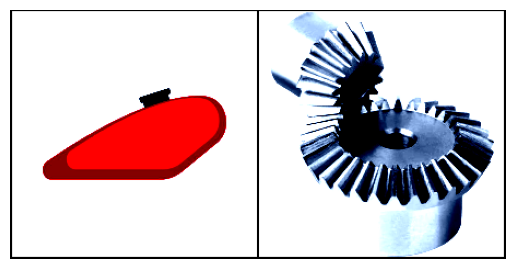

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]


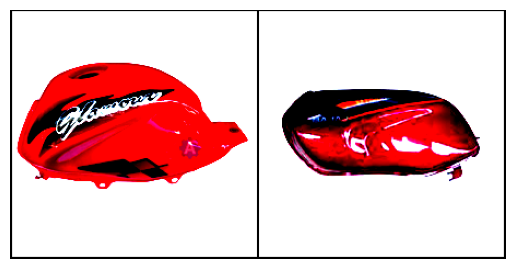

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


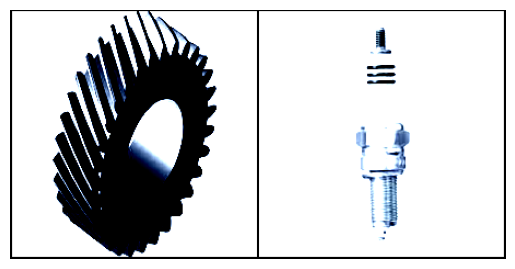

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]


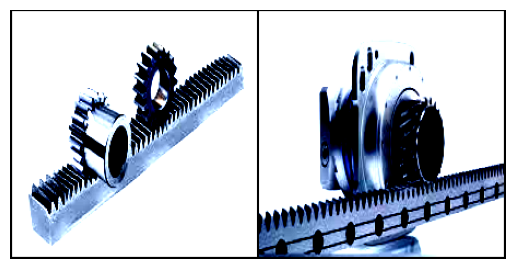

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


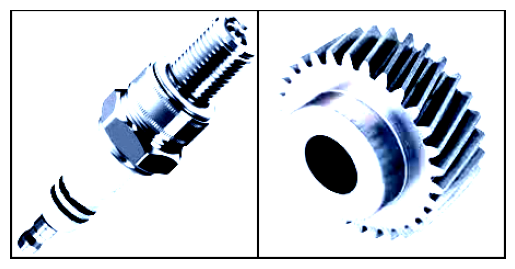

[1.]


In [7]:
vis_dataloader,_ =  get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,1,True)
example_vis(vis_dataloader,FLAG)

In [8]:
train_dataloader,_ = get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,64,True)

In [9]:
net = pretrained_model.SiameseNetwork().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)
if FLAG == 'contrastive':
    criterion = ContrastiveLoss()
elif FLAG == 'triplet':
    criterion = TripletLoss()

h:\anaconda3\envs\torch_capstone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
h:\anaconda3\envs\torch_capstone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
print(net)

SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [11]:
def contrastive_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
        # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_contrastive.item())
    return(loss_history)

In [12]:
def triplet_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    for epoch in tqdm(range(EPOCH), desc="Epochs"):
        # Iterate over batches
        for step, (anchor_img, positive_img, negative_img,_,_,_) in enumerate(train_dataloader,0):
            # Send the images and labels to CUDA
            anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Pass in the three images into the network and obtain three outputs
            anchor_out = net.forward_once(anchor_img)
            positive_out = net.forward_once(positive_img)
            negative_out = net.forward_once(negative_img)
            
            # Pass the outputs of the networks and label into the loss function
            loss_triplet = criterion(anchor_out, positive_out, negative_out)

            # Calculate the backpropagation
            loss_triplet.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_triplet.item())
    return loss_history

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

h:\anaconda3\envs\torch_capstone\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


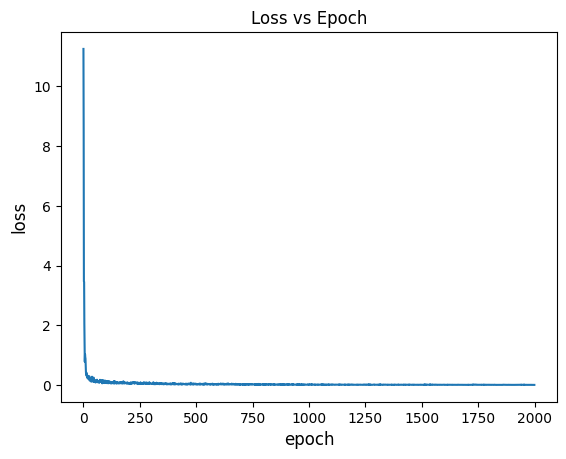

In [13]:
if FLAG == 'contrastive':
    train_loss = contrastive_train(net,optimizer,criterion)
    # _,train_loss = train()
elif FLAG == 'triplet':
    train_loss = triplet_train(net,optimizer,criterion)
plt.figure()
plt.title('Loss vs Epoch')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
counter = list(range(len(train_loss)))
show_plot(counter, train_loss)

In [14]:
PATH = "my_trained_model_auto.pt"

torch.save(net.state_dict(), PATH)


In [15]:
model = pretrained_model.SiameseNetwork().to(device)  # create an instance of your model class
model.load_state_dict(torch.load(PATH))
model.eval()

SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [16]:
# # Save the trained model using pickle
# with open("trained_model.pkl", "wb") as f:
#     pickle.dump(net, f)

# # Load the saved model using pickle
# with open("trained_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

# loaded_model.eval()  # Set

In [33]:
PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\data\Automobile-parts"

In [34]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
if testing:
    test_dataloader,_ = get_dataset(joinpath(PATH,'test'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, True)

    # Grab one image that we are going to test
    dataiter = iter(test_dataloader)
    x0,_ = next(dataiter)


    #### here we create dataiter for train.

    # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
    train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)

    dataiter_train = iter(train_dataloader)

    score = []

    for i in range(len(siamese_dataset_train)):
        # Iterate over all images and test them with the first image (x0)
        x1,_ = next(dataiter_train)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        
        output1, output2 = net(x0.cto(device), x1.to(device))
        euclidean_distance = F.pairwise_distance(output1, output2)
        score.append(round(euclidean_distance.item(),2))
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        # cosine_distance = torch.cosine_similarity(output1, output2)
        # score.append(round(cosine_distance.item(),2))
        # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

In [35]:
#### here we create dataiter for test

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, True)

#### here we create dataiter for train

train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]


dataiter = iter(test_dataloader)
for i in tqdm(range(len(siamese_dataset)),desc='TestCount'):
    
    x0,label0 = next(dataiter)
    # count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        # count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = net(x0.to(device), x1.to(device))
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())

        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

TestCount:   0%|          | 0/44 [00:00<?, ?it/s]

h:\anaconda3\envs\torch_capstone\lib\site-packages\PIL\Image.py:996: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [36]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

Number of total interesection:  4148


In [37]:
import pickle

# open a file in binary write mode
with open('lists_auto.pkl', 'wb') as f:
    # pickle the two lists
    pickle.dump(same_disssimilarity, f)
    pickle.dump(different_disssimilarity, f)


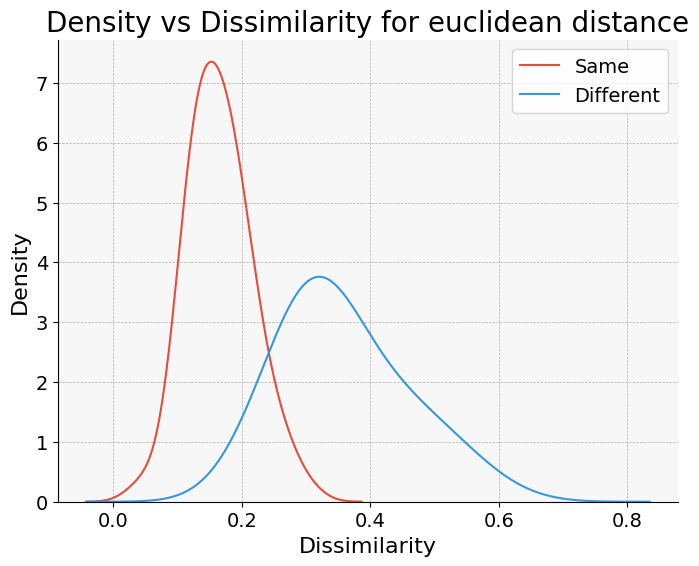

In [38]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.kdeplot(same_disssimilarity, bw_method=0.5, label="Same", color=colors[0])
sns.kdeplot(different_disssimilarity, bw_method=0.5, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()


In [39]:
# checking for mean/average score
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

Mean of same images:  0.1651602869646417
Mean of different images:  0.3587142592933443


In [40]:
# Prinitng total number of combinations that we tested on
print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

Total number of combinations of same images:  900
Total number of combinations of different images:  9000
Total number of combinations:  9900


In [41]:
# Checking for number of missclassified images
final_list, same_misclassified, different_misclassified = threshold(same_disssimilarity,different_disssimilarity,THRESHOLD_SCORE)

print("Total number of missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(final_list))
print("Total number of same class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(same_misclassified))
print("Total number of different class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(different_misclassified))

Total number of missclassified for threshold score  1  missclassified images:  9000
Total number of same class missclassified for threshold score  1  missclassified images:  0
Total number of different class missclassified for threshold score  1  missclassified images:  9000


In [42]:
embedding_dataloader, embedding_dataset = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)

dict_embeddings = create_embeddings(net, device, embedding_dataloader, embedding_dataset)
dict_mean = mean_embeddings(dict_embeddings)

h:\anaconda3\envs\torch_capstone\lib\site-packages\PIL\Image.py:996: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [43]:
# test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), transformation, TestNetworkDataset, FLAG, 0, 1, False)
# dataiter = iter(test_dataloader)
# image, label = next(dataiter)

# print(label[0])
# n_way_dict = n_way_shot_learning(net, device, image, dict_mean, THRESHOLD_SCORE)
# print(n_way_dict)

In [44]:
my_list = [round(x * 0.01, 2) for x in range(-300, 301)]
final = []
same = []
different = []
for i in my_list:
    a,b,c = threshold(same_disssimilarity,different_disssimilarity,i)
    final.append(len(a))
    same.append(len(b))
    different.append(len(c))

In [45]:
import plotly.express as px

# create the line plot
fig = px.line(x=my_list, y=final)

# set the x-axis range to -1 to 1 and y-axis range to -100 to 2500
fig.update_xaxes(range=[-1, 2])
fig.update_yaxes(range=[-100, 5000])

# add a vertical line at x=0.2
fig.add_shape(type='line', x0=0.2, x1=0.2,
              y0=0, y1=max(final),
              line=dict(color='red', width=1, dash='dash'),
              name='Minimum Number of Misclassification')

fig.update_layout(
    title={
        'text': 'Total missclassification vs threshold',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Threshold',
    yaxis_title='Missclassified images',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    showlegend=True
)
# display the plot
fig.show()

In [46]:
import plotly.graph_objects as go

# create trace for the first line
trace1 = go.Scatter(x=my_list, y=same, mode='lines', name='Same class Images')

# create trace for the second line
trace2 = go.Scatter(x=my_list, y=different, mode='lines', name='Different class Images')

# create the figure object and add both traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# set the x-axis range to -1 to 1 and y-axis range to -100 to 2500
fig.update_xaxes(range=[-0.5, 1.5])
fig.update_yaxes(range=[-100, 1500])

# find the intersection point of the two lines
intersection_point = my_list[same.index(max(same))]

# add a vertical line at x=0.2
fig.add_shape(type='line', x0=0.19, x1=0.19,
              y0=0, y1=max(final),
              line=dict(color='red', width=1, dash='dash'),
              name='Intersection of both')


fig.update_layout(
    title={
        'text': 'Optimal Threshold Value for Minimum Misclassification',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Threshold',
    yaxis_title='Missclassified images',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    showlegend=True
)

# display the plot
fig.show()


In [53]:
test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, 
                                            TestNetworkDataset, FLAG, 0, 1, False)

report, execution_time, avg_time_image = test_report(net, device, test_dataloader, test_dataset, dict_mean, 0.2)

  0%|          | 0/44 [00:00<?, ?it/s]

h:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\embeddings\n_way_shot_learning.py:18: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

h:\anaconda3\envs\torch_capstone\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

h:\anaconda3\envs\torch_capstone\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

h:\anaconda3\envs\torch_capstone\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this

In [54]:
print(report)
print("Execution time per image: ", mean(avg_time_image), " seconds")
print("Execution time: ", execution_time, " seconds")

                 precision    recall  f1-score   support

     Bevel-gear       1.00      1.00      1.00         4
  Unknown Class       0.00      0.00      0.00         0
bearing_discuss       1.00      1.00      1.00         4
         clutch       1.00      1.00      1.00         4
      fuel-tank       1.00      1.00      1.00         4
   helical_gear       0.60      0.75      0.67         4
         piston       1.00      0.75      0.86         4
    rack-pinion       1.00      0.25      0.40         4
        shocker       0.57      1.00      0.73         4
     spark-plug       0.75      0.75      0.75         4
      spur-gear       0.50      0.25      0.33         4
          wheel       0.80      1.00      0.89         4

       accuracy                           0.80        44
      macro avg       0.77      0.73      0.72        44
   weighted avg       0.84      0.80      0.78        44

Execution time per image:  0.030438769947398792  seconds
Execution time:  1.349819898